# Objetivo: Regressão no dataset “Real estate valuation” (UCI) com modelos do scikit-learn

    Reaproveitar suas funções utilitárias (aux.*) para métricas (incluindo Hit@10), correlações e análise de resíduos.

    Avaliar modelos adicionais além de Perceptron Logístico/MLP:
    SVR (linear/rbf), DecisionTreeRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor.

    Comparar 4 tratamentos de features: sem normalização, z-score, min-max e interquartil (IQR).

    Selecionar o melhor absoluto priorizando Hit@10 (depois Hit@20, R² e, por fim, RMSE menor).

    Manter k-fold e toda a impressão/análise via aux.imprimir_metricas, aux.imprimir_correlacoes e aux.analisar_residuos.


In [1]:
# Real estate valuation — baseline rápido (sklearn)
# - Hold-out 66/33 (final)
# - K-Fold=5 apenas no treino (seleção de modelo+normalização)
# - Modelos default + scalers [none, zscore, minmax, iqr]
# - Critério: Hit@10 > Hit@20 > R² > RMSE
# - Impressões: melhor global (CV no treino + hold-out 33%), resíduos só no hold-out

import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Modelos (DEFAULTS)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, BaggingRegressor
)

# Utilitários do seu pacote
from trabalho_ic_aplicada.models import aux

2025-08-21 18:14:49.652 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada


In [2]:

# -------------------- Configuração --------------------
K_FOLDS = 5  # k-fold só no treino (rápido)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

SHOW_PROGRESS = True  # prints curtos de progresso por combinação
SHOW_BEST_PER_MODEL = False  # se True, imprime resumo do melhor por modelo (sem resíduos)

In [3]:

# -------------------- Dados --------------------------
uci = fetch_ucirepo(id=477)
X_full = uci.data.features.to_numpy()  # remove a 1ª coluna (data)
y_full = uci.data.targets.to_numpy().ravel()

# Hold-out 66/33
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.33, random_state=RANDOM_STATE
)

# Folds só no TREINO
k_fold_train = aux.validacao_cruzada_kfold(X_train, y_train, k=K_FOLDS)


In [4]:

# -------------------- Scalers e ranking ---------------
def make_scaler(kind: str):
    if kind == "none":   return "passthrough"
    if kind == "zscore": return StandardScaler()
    if kind == "minmax": return MinMaxScaler()
    if kind == "iqr":    return RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25, 75))
    raise ValueError(f"Escalonador desconhecido: {kind}")


def rank_df(df: pd.DataFrame) -> pd.DataFrame:
    # Hit@10 desc, Hit@20 desc, R² desc, RMSE asc
    return df.sort_values(
        by=["Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"],
        ascending=[False, False, False, True],
        na_position="last"
    ).reset_index(drop=True)


def safe_corr(a, b) -> float:
    if np.std(a) == 0 or np.std(b) == 0: return 0.0
    return float(np.corrcoef(a, b)[0, 1])


# -------------------- Avaliação CV (treino) -----------
def evaluate_model_cv(model_name, model, scaler_kind, X, y, folds):
    eqm, rmse, r2, h20, h10 = [], [], [], [], []
    c_tr, c_te = [], []
    ytr, ytrp, yte, ytep = [], [], [], []

    pipe = Pipeline([("scaler", make_scaler(scaler_kind)), ("model", model)])

    for tr_idx, te_idx in folds:
        X_tr, X_va = X[tr_idx], X[te_idx]
        y_tr, y_va = y[tr_idx], y[te_idx]

        pipe.fit(X_tr, y_tr)
        y_tr_pred = pipe.predict(X_tr)
        y_va_pred = pipe.predict(X_va)

        c_tr.append(safe_corr(y_tr, y_tr_pred))
        c_te.append(safe_corr(y_va, y_va_pred))

        e, r, r_2, hh20, hh10, _ = aux.calcular_metricas(y_va, y_va_pred, aux)
        eqm.append(e);
        rmse.append(r);
        r2.append(r_2);
        h20.append(hh20);
        h10.append(hh10)

        ytr.extend(y_tr);
        ytrp.extend(y_tr_pred);
        yte.extend(y_va);
        ytep.extend(y_va_pred)

    return {
        "summary": {
            "model": model_name,
            "scaler": scaler_kind,
            "R2_mean": float(np.mean(r2)),
            "RMSE_mean": float(np.mean(rmse)),
            "Hit@20_mean": float(np.mean(h20)),
            "Hit@10_mean": float(np.mean(h10)),
        },
        "fold_metrics": (eqm, rmse, r2, h20, h10),
        "corrs": (c_tr, c_te),
        "y_all": (np.array(ytr), np.array(ytrp), np.array(yte), np.array(ytep)),
    }

In [5]:


# -------------------- Modelos DEFAULT -----------------
models = {
    # "SVR(linear)": SVR(kernel="linear"),  # C=1.0, epsilon=0.1
    "SVR(rbf)": SVR(kernel="rbf"),  # gamma="scale"
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "ExtraTrees": ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE),
}
scalers = ["none", "zscore", "minmax", "iqr"]

In [6]:

# -------------------- Loop (CV no TREINO) -------------
rows = []
results = []
total = len(models) * len(scalers)
done = 0

for mname, mdl in models.items():
    for sc in scalers:
        done += 1
        res = evaluate_model_cv(mname, clone(mdl), sc, X_train, y_train, k_fold_train)
        rows.append(res["summary"])
        results.append(res)

        if SHOW_PROGRESS:
            print(f"[{done:02d}/{total}] {mname:>15} | scaler={sc:<6} "
                  f"→ Hit@10={res['summary']['Hit@10_mean']:.4f}")

[01/20]        SVR(rbf) | scaler=none   → Hit@10=0.4050
[02/20]        SVR(rbf) | scaler=zscore → Hit@10=0.3865
[03/20]        SVR(rbf) | scaler=minmax → Hit@10=0.3826
[04/20]        SVR(rbf) | scaler=iqr    → Hit@10=0.4299
[05/20]    DecisionTree | scaler=none   → Hit@10=0.4293
[06/20]    DecisionTree | scaler=zscore → Hit@10=0.4293
[07/20]    DecisionTree | scaler=minmax → Hit@10=0.4293
[08/20]    DecisionTree | scaler=iqr    → Hit@10=0.4293
[09/20]    RandomForest | scaler=none   → Hit@10=0.5240
[10/20]    RandomForest | scaler=zscore → Hit@10=0.5240
[11/20]    RandomForest | scaler=minmax → Hit@10=0.5203
[12/20]    RandomForest | scaler=iqr    → Hit@10=0.5240
[13/20]      ExtraTrees | scaler=none   → Hit@10=0.5202
[14/20]      ExtraTrees | scaler=zscore → Hit@10=0.5166
[15/20]      ExtraTrees | scaler=minmax → Hit@10=0.5166
[16/20]      ExtraTrees | scaler=iqr    → Hit@10=0.5166
[17/20] GradientBoosting | scaler=none   → Hit@10=0.4985
[18/20] GradientBoosting | scaler=zscore → Hit@

In [7]:

# -------------------- Ranking (CV no TREINO) ----------
df_rank = rank_df(pd.DataFrame(rows))
print("\n### TOP 8 no TREINO (CV k=5) — prioridade: Hit@10 > Hit@20 > R² > RMSE")
print(df_rank[["model", "scaler", "Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"]].head(8).to_string(index=False))

best = df_rank.iloc[0].to_dict()
best_obj = next(r for r in results
                if r["summary"]["model"] == best["model"] and r["summary"]["scaler"] == best["scaler"])

# (Opcional) métricas CV detalhadas do melhor do treino
eqm_cv, rmse_cv, r2_cv, h20_cv, h10_cv = best_obj["fold_metrics"]
c_tr_cv, c_te_cv = best_obj["corrs"]
print("\n" + "=" * 80)
print(f"MELHOR NO TREINO (CV k={K_FOLDS}) → {best['model']} | scaler={best['scaler']}")
aux.imprimir_metricas(eqm_cv, rmse_cv, r2_cv, h20_cv, h10_cv)
aux.imprimir_correlacoes(c_tr_cv, c_te_cv, r2_cv)


### TOP 8 no TREINO (CV k=5) — prioridade: Hit@10 > Hit@20 > R² > RMSE
       model scaler  Hit@10_mean  Hit@20_mean  R2_mean  RMSE_mean
RandomForest zscore     0.523955     0.776587 0.588116   8.684765
RandomForest   none     0.523955     0.776459 0.589659   8.667309
RandomForest    iqr     0.523955     0.776459 0.588129   8.684940
RandomForest minmax     0.520319     0.776459 0.589016   8.674073
  ExtraTrees   none     0.520191     0.787496 0.628806   8.429515
  ExtraTrees    iqr     0.516555     0.787496 0.630002   8.413983
  ExtraTrees zscore     0.516555     0.787496 0.630002   8.413983
  ExtraTrees minmax     0.516555     0.787496 0.630002   8.413983

MELHOR NO TREINO (CV k=5) → RandomForest | scaler=zscore
Erro Quadrático Médio (EQM): 81.6154 ± 46.1188
Raiz do Erro Quadrático Médio (REQM): 8.6848 ± 2.4880
Hit rate 20%: 0.7766 ± 0.0319
Hit rate 10%: 0.5240 ± 0.0431

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.9778 ± 0.0021
Correlação Média


=== HOLD-OUT (33% dos dados) — AVALIAÇÃO FINAL ===
R²=0.7211 | RMSE=6.6889 | EQM=44.7411 | Hit@10=0.5693 | Hit@20=0.7883
--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.9755 ± 0.0000
Correlação Média (Teste): 0.8574 ± 0.0000
Coeficiente de Determinação (R²): 0.7211 ± 0.0000

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8284, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.9089, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


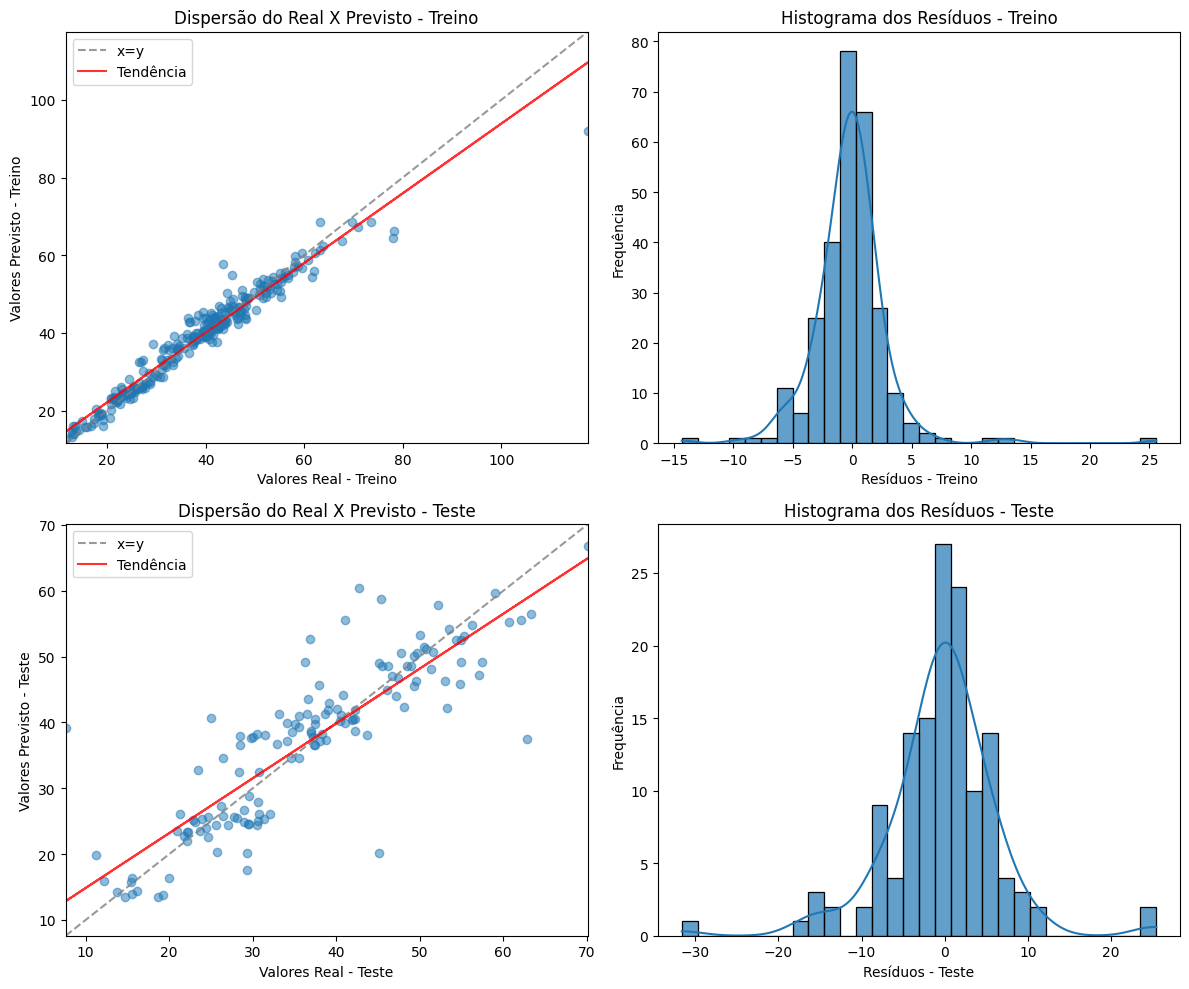

Avg. house price: 37.0904 ± 12.3051
RSME/Avg. house price: 0.1325 ± 0.1620


(np.float64(37.09040815085158),
 np.float64(12.305076271829927),
 np.float64(0.13245951450836072),
 np.float64(0.16204603569501547))

In [8]:

# -------------------- Treino FINAL no TREINO (100%) e teste no HOLD-OUT (33%) ----
final_pipe = Pipeline([
    ("scaler", make_scaler(best["scaler"])),
    ("model", clone(models[best["model"]]))
])
final_pipe.fit(X_train, y_train)

y_tr_pred = final_pipe.predict(X_train)
y_te_pred = final_pipe.predict(X_test)

# Métricas hold-out
eqm_te, rmse_te, r2_te, hit20_te, hit10_te, _ = aux.calcular_metricas(y_test, y_te_pred, aux)
print("\n=== HOLD-OUT (33% dos dados) — AVALIAÇÃO FINAL ===")
print(f"R²={r2_te:.4f} | RMSE={rmse_te:.4f} | EQM={eqm_te:.4f} | Hit@10={hit10_te:.4f} | Hit@20={hit20_te:.4f}")

# Correlações + Resíduos (apenas hold-out, como pedido)
corr_tr = safe_corr(y_train, y_tr_pred)
corr_te = safe_corr(y_test, y_te_pred)
aux.imprimir_correlacoes([corr_tr], [corr_te], [r2_te])

aux.analisar_residuos(
    y_train, y_tr_pred,
    y_test, y_te_pred,
    aux,
    titulo=f"Hold-out (final) — {best['model']} | scaler={best['scaler']}"
)

aux.calcular_metricas_normalizadas(y_te_pred, y_test)

In [9]:

# -------------------- Melhor por modelo (apenas resumo) -----------
if SHOW_BEST_PER_MODEL:
    print("\n" + "#" * 80)
    print("MELHOR POR MODELO (CV no treino, resumo)")
    for mname in df_rank["model"].unique():
        best_row = rank_df(df_rank[df_rank["model"] == mname].copy()).iloc[0].to_dict()
        print(f"- {mname:>15} | scaler={best_row['scaler']:<6} "
              f"| Hit@10={best_row['Hit@10_mean']:.4f} | Hit@20={best_row['Hit@20_mean']:.4f} "
              f"| R²={best_row['R2_mean']:.4f} | RMSE={best_row['RMSE_mean']:.4f}")
